In [2]:
import sys
sys.path.append('/Users/mnannan/dev/supelec/ngsa/assignments/Assignement 2 ')

In [3]:
from core.io.loader import *

In [4]:
from features.authors import *

In [5]:
import matplotlib.pyplot as plt

In [6]:
from plot.boxplot import *

In [7]:
%matplotlib inline

In [ ]:
train = get_data_with_node_information('train', data_dir='../data')

train['source_authors_list'] = train.source_authors.apply(lambda x: extract_authors_list(x))

train['target_authors_list'] = train.target_authors.apply(lambda x: extract_authors_list(x))

In [7]:
source_authors_list = []
target_authors_list = []
df = train[['source_id', 'source_authors_list']].drop_duplicates('source_id')
for source_id, authors in zip(df.source_id.values, df.source_authors_list.values):
    if authors:
        for author in authors:
            source_authors_list.append((source_id, author))
df = train[['target_id', 'target_authors_list']].drop_duplicates('target_id')
for target_id, authors in zip(df.target_id.values, df.target_authors_list.values):
    if authors:
        for author in authors:
            target_authors_list.append((target_id, author))

In [8]:
target_authors = pd.DataFrame(target_authors_list)
target_authors = target_authors.rename({0:'paper_id', 1:'author'}, axis='columns')

source_authors = pd.DataFrame(source_authors_list)
source_authors = source_authors.rename({0:'paper_id', 1:'author'}, axis='columns')

In [9]:
colaboration = source_authors.merge(source_authors, left_on='paper_id', right_on='paper_id', suffixes=('_1','_2'))
colaboration = colaboration[colaboration.author_1 != colaboration.author_2]
merge_authors = colaboration.author_1.astype('str') + ',' + colaboration.author_2.astype('str')
merge_authors = merge_authors.apply(lambda x: ''.join(sorted(x.split(','))))
colaboration['merge_authors'] = merge_authors



In [10]:
colaboration['has_colaborated'] = True

In [11]:
colaboration = colaboration.drop(columns=['author_1', 'author_2', 'paper_id']).drop_duplicates()

In [12]:
colaboration.shape

(21828, 2)

In [14]:
authors_colaboration = train[['source_id', 'target_id']]\
.merge(source_authors, left_on='source_id',right_on='paper_id', how='outer')\
.merge(target_authors, left_on='target_id',right_on='paper_id', how='outer', suffixes=('_source', '_target'))\
.drop(['paper_id_source', 'paper_id_target'], axis='columns')

In [15]:
authors_colaboration[:1]

,source_id,target_id,author_source,author_target
0,9510123,9502114,NaN,wontkim


In [16]:
authors_colaboration = authors_colaboration.dropna(subset=['author_source', 'author_target'])

In [17]:
authors_colaboration[:1]

,source_id,target_id,author_source,author_target
3,9604093,9502114,jgzhou,wontkim


In [18]:
concat_authors = authors_colaboration.author_source.astype('str') + ',' + authors_colaboration.author_target.astype('str')
concat_authors = concat_authors.apply(lambda x: ''.join(sorted(x.split(','))))

authors_colaboration['merge_authors'] = concat_authors


In [19]:
authors_colaboration.shape

(2257141, 5)

In [20]:
authors_colaboration[:1]

,source_id,target_id,author_source,author_target,merge_authors
3,9604093,9502114,jgzhou,wontkim,jgzhouwontkim


In [21]:
authors_colaboration = authors_colaboration.drop(columns=['author_source', 'author_target'])

In [22]:
authors_colaboration.shape

(2257141, 3)

In [23]:
colaboration[:1]

,merge_authors,has_colaborated
1,jgzhouygmiao,True


In [24]:
authors_colaboration = authors_colaboration\
.merge(colaboration, on='merge_authors', how='left')


In [25]:
authors_colaboration.shape

(2257141, 4)

In [26]:
authors_colaboration = authors_colaboration.dropna(subset=['has_colaborated']).drop(columns=['has_colaborated'])\
.groupby(['source_id','target_id']).count().rename({'merge_authors':'number_of_colaborations'}, axis='columns')

In [144]:
authors_colaboration[authors_colaboration.number_of_colaborations == 4]

number_of_colaborations
source_id target_id                         
1002      9904017                          4
          9906194                          4
1005      9909114                          4
1010      9901128                          4
1024      9909098                          4
1041      9901121                          4
1053      9812046                          4
1071      9910021                          4
1074      9805106                          4
          9809068                          4
          9905011                          4
          9907102                          4
1081      9708077                          4
          9807023                          4
1083      9709058                          4
          9710078                          4
          9809039                          4
          9812139                          4
          9903113                          4
          9910115                          4
1096      9709158                          4
1107      1003                             4
1114      9704137                          4
          9806068                          4
1122      9810008                          4
          9905200                          4
          9906216                          4
          9911152                          4
1124      9401137                          4
          9612069                          4
...                                      ...
9912176   9710101                          4
9912177   9912159                          4
9912181   9605053                          4
9912191   9810008                          4
          9905200                          4
          9906216                          4
9912196   9711113                          4
          9803005                          4
9912197   102118                           4
9912206   9905139                          4
9912214   9710063                          4
          9712205                          4
9912222   9901003                          4
9912245   9905170                          4
9912248   9803212                          4
9912250   9908160                          4
9912258   9910004                          4
9912264   9708003                          4
9912271   9609041                          4
          9609145                          4
          9610156                          4
9912272   9901008                          4
9912280   9806236                          4
9912285   9705124                          4
          9807217                          4
9912288   9804095                          4
          9903054                          4
          9910083                          4
          9911031                          4
9912292   9901003                          4

[5727 rows x 1 columns]

In [36]:
train = train.merge(authors_colaboration, on=['source_id', 'target_id'], how='left')\
.fillna({'number_of_colaborations':0})

###### Number of colaboration found

In [34]:
authors_colaboration.shape[0]

50711

###### Proportion of pair source/ target with colaboration

In [35]:
authors_colaboration.shape[0]/train.shape[0]

0.08238832061763215

In [43]:
positive = train.category == 1

In [44]:
negative = train.category == 0

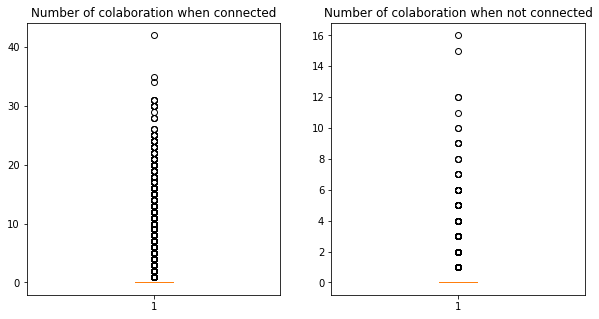

In [46]:
box_plot_feature(train.number_of_colaborations, positive=positive, negative=negative, title='Number of colaboration')

###### Category repartition among those who have already colaborated

In [51]:
train[(train.number_of_colaborations > 0)].category.value_counts()

1    49435
0     1276
Name: category, dtype: int64

In [52]:
100*49435/(49435+1276)

97.48378063930903

97% of pair source/target where people have already colaborated are linked